In [2]:
mkdir -p ~/work/songys_chatbot

In [ ]:
"""
2. 트랜스포머 구조 살펴보기
앞서 소개했듯, 오늘 여러분들이 실습해보실 모델은 ‘트랜스포머’입니다. 2017년에 발표된 트랜스포머는 자연어 처리 분야를 넘어 이미지 인식 분야에도 큰 영향을 끼쳤으며, 2024년 초까지도 ChatGPT-3, SORA 등 다양한 분야에서 SOTA 모델들이 이 구조를 차용하고 있습니다. 그만큼 많이 중요한 모델이니, 학습 내용을 잘 따라오시기 바랄게요!

트랜스포머는 RNN, LSTM 등을 거치며 기존의 복잡해지는 순환 층이나 합성곱 층을 전부 제외하고, 어텐션 매커니즘만으로 구성된 모델입니다.
뒤쪽에서 모델 구조의 각 부분을 자세히 설명하기 전에, 전체 구조를 먼저 살펴보고 넘어가겠습니다.
"""

In [3]:
# 4. 트랜스포머의 입력 이해하기
# 먼저 앞으로 진행하면서 필요한 패키지를 임포트하겠습니다!
!pip install sentencepiece

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import sentencepiece as spm

import math
import os
import re
import urllib.request
import zipfile
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# 포지셔널 행렬을 직접 구현해서 눈으로 확인해 봅시다!
class PositionalEncoding(nn.Module):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.position = position

        self.pos_encoding = self._build_pos_encoding(position, d_model)

    def _get_angles(self, position, i, d_model):
        return 1.0 / (10000.0 ** ((2.0 * (i // 2)) / d_model)) * position

    def _build_pos_encoding(self, position, d_model):
        pos = torch.arange(position, dtype=torch.float32).unsqueeze(1)
        i = torch.arange(d_model, dtype=torch.float32).unsqueeze(0)

        angle_rads = self._get_angles(pos, i, d_model)
        sines = torch.sin(angle_rads[:, 0::2])
        cosines = torch.cos(angle_rads[:, 1::2])

        pos_encoding = torch.zeros(position, d_model)
        pos_encoding[:, 0::2] = sines
        pos_encoding[:, 1::2] = cosines

        pos_encoding = pos_encoding.unsqueeze(0)  # shape: [1, position, d_model]
        return pos_encoding

    def forward(self, x):
        return x + self.pos_encoding[:, :x.size(1), :].to(x.device)

In [ ]:
"""
행의 크기가 50, 열의 크기가 512인 행렬을 그려봅시다. 이를테면, 최대 문장의 길이가 50이고 워드 임베딩 차원을 512로 하는 모델의 입력 벡터 모양이 이와 같을 것입니다.

Q.위의 문장처럼 행의 크기가 50, 열의 크기가 512인 행렬을 만드는 코드를 완성하여 입력 벡터 모양을 시각화하세요.

(추가 : 아래 퀴즈를 풀면서 작성한 코드를 변경해보세요.)
"""

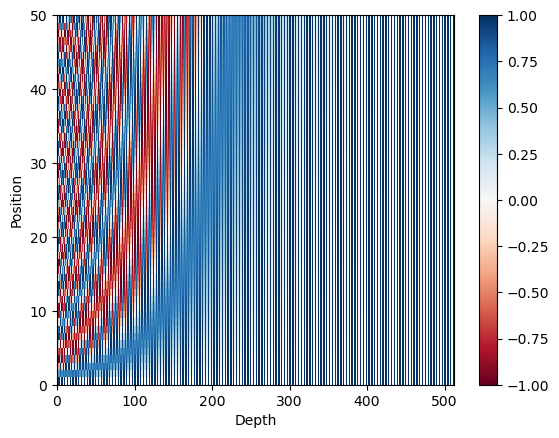

In [7]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [ ]:
"""
Q. 임베딩 벡터의 차원이 256이고 최대 문장의 길이가 30인 텍스트를 입력으로 하는 트랜스포머를 구현한다고 하였을 때, 적절한 포지셔널 인코딩 행렬의 크기를 추측해보고 위에 구현한 포지셔널 인코딩 레이어를 사용해 표현해 보세요.
"""

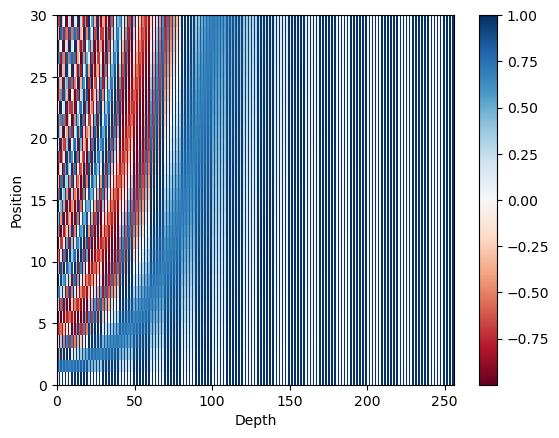

In [9]:
sample_pos_encoding = PositionalEncoding(30, 256)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 256))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [10]:
#스케일드 닷 프로덕트 어텐션 함수를 구현해봅시다.

def scaled_dot_product_attention(query, key, value, mask=None):

    # 1) Q와 K의 내적을 통해 score(유사도) 계산
    # key.transpose(-1, -2): (batch_size, heads, depth, seq_len)
    # matmul 결과 shape: (batch_size, heads, seq_len, seq_len)
    matmul_qk = torch.matmul(query, key.transpose(-1, -2))

    # 2) depth에 따라 정규화
    depth = key.size(-1)  # depth = d_model / heads
    logits = matmul_qk / math.sqrt(depth)

    # 3) 마스크가 주어졌다면 -1e9(아주 작은 값)를 더해 소프트맥스에서 제외시키도록 함
    if mask is not None:
        # 텐서플로우: logits += (mask * -1e9)
        # 파이토치 동일 적용
        logits = logits + (mask * -1e9)

    # 4) 소프트맥스 계산해 attention weights 생성
    attention_weights = F.softmax(logits, dim=-1)

    # 5) attention weights와 value의 내적
    output = torch.matmul(attention_weights, value)

    return output, attention_weights

In [12]:
# 멀티 헤드 어텐션을 구현하면 다음과 같습니다.
# 내부적으로는 스케일드 닷 프로덕트 어텐션 함수를 호출합니다.
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        # d_model은 num_heads로 나누어떨어져야 함
        assert d_model % num_heads == 0

        self.depth = d_model // num_heads

        # 파이토치에서 Dense는 nn.Linear로 대응
        self.query_dense = nn.Linear(d_model, d_model)
        self.key_dense = nn.Linear(d_model, d_model)
        self.value_dense = nn.Linear(d_model, d_model)

        self.out_dense = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        """
        x: (batch_size, seq_len, d_model)
        => (batch_size, num_heads, seq_len, depth) 형태로 변환
        """
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        x = x.permute(0, 2, 1, 3)  # (batch_size, num_heads, seq_len, depth)
        return x

    def forward(self, query, key, value, mask=None):
        """ 
        query, key, value: (batch_size, seq_len, d_model)
        mask: (batch_size, 1, seq_len, seq_len) 등으로 broadcast 가능하도록 구성
        """
        batch_size = query.size(0)

        # Q, K, V에 각각 Linear 적용
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # Head 분할
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)

        # (batch_size, num_heads, seq_len, depth) -> (batch_size, seq_len, num_heads, depth)
        scaled_attention = scaled_attention.permute(0, 2, 1, 3).contiguous()

        # 다시 (batch_size, seq_len, d_model)로 합치기
        concat_attention = scaled_attention.view(batch_size, -1, self.d_model)

        # 최종 Dense
        output = self.out_dense(concat_attention)
        return output


In [13]:
# 다음은 패딩 마스킹을 구현한 함수입니다.
def create_padding_mask(x):
    # x == 0 위치를 찾아 float형 1로 변환
    mask = (x == 0).float()
    # (batch_size, seq_len) -> (batch_size, 1, 1, seq_len)
    mask = mask.unsqueeze(1).unsqueeze(2)
    return mask

In [14]:
# 이 함수에 정수 시퀀스를 입력으로 하면, 이 함수는 숫자가 0인 부분을 체크한 벡터를 리턴합니다.
# 두 개의 정수 시퀀스를 입력으로 해보고, 각각 어떤 결과가 나오는지 보겠습니다.
x = torch.tensor([[1, 2, 0, 3, 0],
                  [0, 0, 0, 4, 5]])
mask = create_padding_mask(x)
print("입력 텐서 크기 :", x.shape)    # (2, 5)
print("생성된 마스크 크기 :", mask.shape)  # (2, 1, 1, 5)
print(mask)

입력 텐서 크기 : torch.Size([2, 5])
생성된 마스크 크기 : torch.Size([2, 1, 1, 5])
tensor([[[[0., 0., 1., 0., 1.]]],


        [[[1., 1., 1., 0., 0.]]]])


In [15]:
# 룩 어헤드 마스킹(Look-ahead masking, 다음 단어 가리기)
def create_look_ahead_mask(x):
    seq_len = x.size(1)

    # (seq_len, seq_len) 크기의 하삼각 행렬(tril) 생성 후 1에서 빼서
    # 상삼각이 1, 하삼각(자기 자신 포함)이 0이 되도록 설정
    # => 미래 토큰(자신 인덱스보다 큰 위치) 마스킹
    look_ahead_mask = 1 - torch.tril(torch.ones((seq_len, seq_len)))

    # 패딩 마스크 생성 (shape: (batch_size, 1, 1, seq_len))
    padding_mask = create_padding_mask(x)

    # look_ahead_mask: (seq_len, seq_len) -> (1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(0)
    # -> (1, seq_len, seq_len) -> (1, 1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(1)
    look_ahead_mask = look_ahead_mask.to(x.device)

    # look-ahead 마스크와 패딩 마스크를 합성 (둘 중 하나라도 1이면 마스킹)
    # 최종 shape은 브로드캐스팅으로 (batch_size, 1, seq_len, seq_len)
    combined_mask = torch.max(look_ahead_mask, padding_mask)
    return combined_mask

In [16]:
x = torch.tensor([[1, 2, 3, 4, 5]])
mask_1 = create_look_ahead_mask(x)
print("첫 번째 시퀀스:\n", mask_1, mask_1.shape)

첫 번째 시퀀스:
 tensor([[[[0., 1., 1., 1., 1.],
          [0., 0., 1., 1., 1.],
          [0., 0., 0., 1., 1.],
          [0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 0.]]]]) torch.Size([1, 1, 5, 5])


In [17]:
# 패딩 마스크 포함 시키기
x2 = torch.tensor([[0, 5, 1, 5, 5]])
mask_2 = create_look_ahead_mask(x2)
print("두 번째 시퀀스:\n", mask_2, mask_2.shape)

두 번째 시퀀스:
 tensor([[[[1., 1., 1., 1., 1.],
          [1., 0., 1., 1., 1.],
          [1., 0., 0., 1., 1.],
          [1., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0.]]]]) torch.Size([1, 1, 5, 5])


In [18]:
#두 개의 서브 층을 가지는 하나의 인코더 층을 구현하는 함수는 다음과 같습니다. 
# 함수 내부적으로 첫 번째 서브 층과 두 번째 서브 층을 구현하고 있습니다.
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)  # 이전에 구현한 MHA
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 피드포워드 부분 (Dense -> ReLU -> Dense)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, d_model)
        )
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

    def forward(self, x, mask=None):
        # (1) 멀티 헤드 어텐션 (셀프 어텐션)
        attn_output = self.mha(x, x, x, mask)  # (batch_size, seq_len, d_model)
        attn_output = self.dropout1(attn_output)
        out1 = self.norm1(x + attn_output)     # 잔차 연결 + LayerNorm

        # (2) 피드포워드 신경망
        ffn_output = self.ffn(out1)            # (batch_size, seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.norm2(out1 + ffn_output)   # 잔차 연결 + LayerNorm

        return out2


In [19]:
#이렇게 구현한 인코더 층을 임베딩 층(Embedding layer) 과 포지셔널 인코딩(Positional Encoding) 을 연결하고, 
#사용자가 원하는 만큼 인코더 층을 쌓음으로써 트랜스포머의 인코더가 완성됩니다.

class Encoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
        self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) EncoderLayer 쌓기
        self.enc_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        # (1) 임베딩 & sqrt(d_model)로 스케일링
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 적용 + 드롭아웃
        x = self.pos_encoding(x)  # shape: (batch_size, seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 쌓아올린 EncoderLayer 통과
        for layer in self.enc_layers:
            x = layer(x, mask)

        return x

In [20]:
# 디코더의 세 개의 서브 층을 내부적으로 구현한 디코더의 함수는 다음과 같습니다.
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(DecoderLayer, self).__init__()

        # 첫 번째 서브 레이어 (디코더 내부 셀프 어텐션)
        self.self_mha = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 두 번째 서브 레이어 (인코더-디코더 어텐션)
        self.encdec_mha = MultiHeadAttention(d_model, num_heads)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

        # 세 번째 서브 레이어 (피드포워드 네트워크)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),  # Dense(units=ff_dim)
            nn.ReLU(),                   # activation='relu'
            nn.Linear(ff_dim, d_model)   # Dense(units=d_model)
        )
        self.norm3 = nn.LayerNorm(d_model, eps=1e-6)

        # 드롭아웃
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, enc_outputs, look_ahead_mask=None, padding_mask=None):
        # 1) 셀프 어텐션 (디코더 내부)
        self_attn_out = self.self_mha(x, x, x, mask=look_ahead_mask)
        self_attn_out = self.dropout1(self_attn_out)
        out1 = self.norm1(x + self_attn_out)  # 잔차 연결 + LayerNorm

        # 2) 인코더-디코더 어텐션
        encdec_attn_out = self.encdec_mha(out1, enc_outputs, enc_outputs, mask=padding_mask)
        encdec_attn_out = self.dropout2(encdec_attn_out)
        out2 = self.norm2(out1 + encdec_attn_out)  # 잔차 연결 + LayerNorm

        # 3) 피드포워드 (Dense -> ReLU -> Dense)
        ffn_out = self.ffn(out2)
        ffn_out = self.dropout3(ffn_out)
        out3 = self.norm3(out2 + ffn_out)  # 잔차 연결 + LayerNorm

        return out3


In [21]:
# 디코더 층을 쌓아 디코더 만들기
class Decoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
        # 실제 학습 시에는 최대 시퀀스 길이에 맞추어 쓰기도 함
        self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) DecoderLayer 쌓기
        self.dec_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, enc_outputs, look_ahead_mask=None, padding_mask=None):
        # (1) 임베딩 + sqrt(d_model)로 스케일링
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 + 드롭아웃
        x = self.pos_encoding(x)    # (batch_size, tgt_seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 쌓인 DecoderLayer 통과
        for layer in self.dec_layers:
            x = layer(x, enc_outputs, look_ahead_mask, padding_mask)

        return x

In [ ]:
"""
이제 인코더 층과 디코더 층을 각각 함수로 구현하였습니다.

이를 하나로 조합하여 트랜스포머 모델을 만들 수 있을 텐데, 
우선 그전에 여기서 사용할 챗봇 데이터를 로드하고, 전처리해보겠습니다.
"""

In [22]:
# 코넬 대사 데이터셋 다운로드 URL
url = 'http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip'
zip_filename = 'cornell_movie_dialogs.zip'

# 이미 파일이 없는 경우에만 다운로드
if not os.path.exists(zip_filename):
    print(f"Downloading {zip_filename} ...")
    urllib.request.urlretrieve(url, zip_filename)
    print("Download complete.")

# ZIP 파일 압축 해제
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall()  # 현재 디렉토리에 풀림

# 코넬 대사 데이터 폴더 경로
path_to_dataset = os.path.join(os.getenv('HOME'), "cornell movie-dialogs corpus")

# 개별 파일 경로 설정
path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset, 'movie_conversations.txt')

print("path_to_dataset:", path_to_dataset)
print("path_to_movie_lines:", path_to_movie_lines)
print("path_to_movie_conversations:", path_to_movie_conversations)

Download complete.
path_to_dataset: /home/jovyan/cornell movie-dialogs corpus
path_to_movie_lines: /home/jovyan/cornell movie-dialogs corpus/movie_lines.txt
path_to_movie_conversations: /home/jovyan/cornell movie-dialogs corpus/movie_conversations.txt


In [23]:
#여기서 우리가 사용할 데이터는 실습 시간을 고려하여 전체 데이터 중 일부입니다.
# 우선, 데이터 중에서 5만 개만 가져오도록 하고 질문과 답변의 쌍의 형태로 데이터셋을 가공합니다.
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

50000


In [24]:
# 전처리 함수
def preprocess_sentence(sentence):
  # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence
print("슝=3")

슝=3


In [25]:
# 그럼 방금 만든 전처리 함수를 테스트해보겠습니다.
sample_sentence = "안녕하세요? Hello! I'm a student😊, nice to meet you!"

preprocessed_sentence = preprocess_sentence(sample_sentence)
print(preprocessed_sentence)

? hello ! i m a student , nice to meet you !


In [26]:
# 데이터를 로드하는 동시에 전처리 함수를 호출하여 질문과 답변의 쌍을 전처리합니다.
def read_cornell_data(path_to_movie_lines, path_to_movie_conversations, max_samples=50000):
    id2line = {}
    with open(path_to_movie_lines, 'r', errors='ignore') as f:
        lines = f.readlines()
    for line in lines:
        parts = line.strip().split(" +++$+++ ")
        if len(parts) >= 5:
            line_id = parts[0]
            text = parts[4]
            id2line[line_id] = text

    pairs = []
    with open(path_to_movie_conversations, 'r', errors='ignore') as f:
        conv_lines = f.readlines()
    for line in conv_lines:
        parts = line.strip().split(" +++$+++ ")
        if len(parts) < 4:
            continue
        # 대화 ID 목록 추출: ["L1045","L1044","L1043", ...]
        conv_str = parts[3]
        conv_list = conv_str[1:-1].split(", ")
        conv_list = [c.strip("'") for c in conv_list]  # "'L1045'" -> "L1045"

        # 연속된 두 문장씩 (질문, 답변) 구성
        for i in range(len(conv_list) - 1):
            q_id = conv_list[i]
            a_id = conv_list[i+1]
            q_text = id2line.get(q_id, "")
            a_text = id2line.get(a_id, "")
            # 간단 전처리(소문자 변환 정도만 예시)
            q_text = preprocess_sentence(q_text)
            a_text = preprocess_sentence(a_text)

            pairs.append((q_text, a_text))
            if len(pairs) >= max_samples:
                return pairs
    return pairs

In [28]:
# 이렇게 로드한 데이터의 샘플 수를 확인해 볼까요?
pairs = read_cornell_data(path_to_movie_lines, path_to_movie_conversations, max_samples=MAX_SAMPLES)

print('전체 샘플 수 :', len(pairs))

전체 샘플 수 : 50000


In [29]:
# 1. Tokenizer 학습하기
# 우선 위에서 만든 pair를 텍스트 파일에 저장시키겠습니다.
corpus_file = "clean_corpus.txt"
with open(corpus_file, 'w', encoding='utf-8') as f:
    for q, a in pairs:
        f.write(q + "\n")
        f.write(a + "\n")

In [30]:
# 질문-답변 쌍이 담긴 clean_corpus.txt 파일을 이용해 SentencePiece 모델을 훈련하고, 
# 토크나이저가 담길 model / vocab 파일을 생성하겠습니다.

spm.SentencePieceTrainer.Train(
    input=corpus_file,
    model_prefix="spm_cornell",
    vocab_size=8000,
    character_coverage=1.0,
    model_type="bpe",
    max_sentence_length=999999,
    bos_id=1,  # <s> (Beginning of Sentence) 설정
    eos_id=2,  # </s> (End of Sentence) 설정
    pad_id=0,  # Padding ID 설정
    unk_id=3   # Unknown Token ID 설정
)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: clean_corpus.txt
  input_format: 
  model_prefix: spm_cornell
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 999999
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differ

In [31]:
# 그럼 학습시킨 토크나이저를 불러와 테스트해보겠습니다.
sp = spm.SentencePieceProcessor()
sp.Load("spm_cornell.model")

True

In [32]:
# 예제 문장
sentence = "I'm learning PyTorch with SentencePiece!"

sentence = preprocess_sentence(sentence)
print("전처리 후의 문장:", sentence)

# 1. 토크나이징 (subword 단위로 분할)
tokens = sp.encode(sentence, out_type=str)
print("Tokenized:", tokens)

# 2. 인코딩 (서브워드를 정수 ID로 변환)
encoded = sp.encode(sentence, out_type=int)
print("Encoded:", encoded)

# 3. 디코딩 (정수 ID → 원본 문장 복원)
decoded = sp.decode(encoded)
print("Decoded:", decoded)


전처리 후의 문장: i m learning pytorch with sentencepiece !
Tokenized: ['▁i', '▁m', '▁learning', '▁p', 'y', 't', 'or', 'ch', '▁with', '▁sent', 'ence', 'p', 'iece', '▁!']
Encoded: [6, 13, 4954, 37, 7983, 7971, 36, 119, 113, 1412, 651, 7991, 4122, 69]
Decoded: i m learning pytorch with sentencepiece !


In [33]:
# 데이터를 로드하는 동시에 전처리 함수를 호출하여 질문과 답변의 쌍을 전처리합니다.
class CornellDataset(Dataset):
    def __init__(self, pairs, sp, max_length=40):
        super().__init__()
        self.sp = sp
        self.max_length = max_length
        self.data = []

        for q_text, a_text in pairs:
            # 1) 토크나이즈
            q_ids = sp.EncodeAsIds(q_text)
            a_ids = sp.EncodeAsIds(a_text)

            # 2) [CLS]/[SEP] 같은 별도 스페셜 토큰을 쓸 수도 있으나,
            #    여기서는 SentencePiece 기본 <s>, </s> 등 혹은 사용자 정의 토큰 활용 가능
            #    간단히 <s>=sp.bos_id(), </s>=sp.eos_id()로 가정해본다면:
            #    sp.SetEncodeExtraOptions("bos:eos") 등으로 설정하는 방법도 있음.
            # 여기서는 수동으로 bos/eos id를 붙인다고 가정
            bos_id = sp.bos_id() if sp.bos_id() >= 0 else 1  # 혹은 임의값
            eos_id = sp.eos_id() if sp.eos_id() >= 0 else 2

            q_tokens = [bos_id] + q_ids + [eos_id]
            a_tokens = [bos_id] + a_ids + [eos_id]

            # 3) 길이 제한
            if len(q_tokens) > max_length or len(a_tokens) > max_length:
                continue

            # 4) 고정 길이 패딩
            q_tokens += [0]*(max_length - len(q_tokens))  # 0 -> <pad> 가정
            a_tokens += [0]*(max_length - len(a_tokens))

            # 5) 디코더 입력(dec_input): a_tokens[:-1], 타겟(outputs): a_tokens[1:]
            #    (teacher forcing용)
            dec_input = a_tokens[:-1]
            target = a_tokens[1:]

            self.data.append({
                "enc_input": q_tokens,
                "dec_input": dec_input,
                "target": target
            })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        enc_input = torch.tensor(sample["enc_input"], dtype=torch.long)
        dec_input = torch.tensor(sample["dec_input"], dtype=torch.long)
        target = torch.tensor(sample["target"], dtype=torch.long)
        return enc_input, dec_input, target

In [34]:
dataset = CornellDataset(pairs, sp, max_length=40)

In [35]:
# 데이터셋에서 하나만 가져와보겠습니다.

for encoder_input, decoder_input, decoder_label  in dataset:
    print("텐서 크기 :",encoder_input.size())
    print(encoder_input)
    print(sp.decode(encoder_input.tolist()))
    print(decoder_input)
    print(sp.decode(decoder_input.tolist()))
    print(decoder_label)
    print(sp.decode(decoder_label.tolist()))
    break

텐서 크기 : torch.Size([40])
tensor([   1,  115,   52,  321,   99, 1609,   23,  304, 7997, 7734,   62,   36,
        7978,  271,   61,   61,  891, 6222,  121, 1060,   39, 3631, 7741, 1337,
          15,  141,  280, 1882,  919,  161,   72,   19,  333,  103,    5,  463,
           5,    2,    0,    0])
can we make this quick ? roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad . again .
tensor([   1,  189,   17,    6,  450,   52,   20,  539,  113,  523,   21,  182,
        5984,   17,  156,   57,   10,  358,  113,   14,    5,    2,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0])
well , i thought we d start with pronunciation , if that s okay with you .
tensor([ 189,   17,    6,  450,   52,   20,  539,  113,  523,   21,  182, 5984,
          17,  156,   57,   10,  358,  113,   14,    5,    2,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0

In [36]:
# 3. DataLoader 구성하기
# 위와 같이 데이터를 Dataset 객체로 잘 만들었다면 데이터로더는 다음과 같이 간단하게 만들 수 있습니다.
dataloader = DataLoader(dataset,batch_size=32,shuffle=True)

In [37]:
# 데이터 로더의 경우 일반적인 인덱싱 방식으로 불러올 경우 에러가 나기 때문에 
#아래와 같이 for 문을 활용해 불러옵니다. 
#이미 데이터가 잘 들어있는지는 확인했기 때문에 여기에서는 batch 단위로 잘 불러와지는지만 확인하도록 하겠습니다.
for encoder_input, decoder_input, decoder_label in dataloader:
    print(encoder_input.size())
    print(decoder_input.size())
    print(decoder_label.size())
    break

torch.Size([32, 40])
torch.Size([32, 39])
torch.Size([32, 39])


In [38]:
# 13. 모델 정의 및 학습하기
# 이제 앞서 사용한 인코더 층 함수와 디코더 층 함수를 사용하여 트랜스포머 함수를 정의합니다.
class Transformer(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,      # 인코더/디코더 층 수
                 units,           # feed-forward 네트워크의 중간 차원(ff_dim)
                 d_model,         # 임베딩 및 내부 표현 차원
                 num_heads,       # 멀티헤드 어텐션의 헤드 수
                 dropout=0.1):
        super(Transformer, self).__init__()

        # 인코더
        self.encoder = Encoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout
        )

        # 디코더
        self.decoder = Decoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout
        )

        # 최종 출력층: (d_model) -> (vocab_size)
        self.final_linear = nn.Linear(d_model, vocab_size)

        # 참고: 텐서플로우 코드의 `name="transformer"`는 파이토치에선 보통 사용 안 함

    def forward(self, inputs, dec_inputs):
        # 1) 인코더 패딩 마스크 생성
        enc_padding_mask = create_padding_mask(inputs)     # shape (batch_size, 1, 1, src_seq_len)

        # 2) 디코더 look-ahead + 패딩 마스크
        look_ahead_mask = create_look_ahead_mask(dec_inputs)  # shape (batch_size, 1, tgt_seq_len, tgt_seq_len)

        # 3) 디코더에서 인코더 출력 쪽을 마스킹할 때 쓸 패딩 마스크
        dec_padding_mask = create_padding_mask(inputs)        # shape (batch_size, 1, 1, src_seq_len)

        # 4) 인코더 수행
        enc_outputs = self.encoder(
            x=inputs,
            mask=enc_padding_mask
        )  # shape: (batch_size, src_seq_len, d_model)

        # 5) 디코더 수행
        dec_outputs = self.decoder(
            x=dec_inputs,           # (batch_size, tgt_seq_len)
            enc_outputs=enc_outputs,# (batch_size, src_seq_len, d_model)
            look_ahead_mask=look_ahead_mask,
            padding_mask=dec_padding_mask
        )  # shape: (batch_size, tgt_seq_len, d_model)

        # 6) 최종 Dense (vocab_size)
        logits = self.final_linear(dec_outputs)  # (batch_size, tgt_seq_len, vocab_size)
        return logits

In [39]:
# 1. 모델 생성

# 예: 하이퍼파라미터 설정
NUM_LAYERS = 2     # 인코더/디코더 층 수
D_MODEL = 256      # 임베딩 및 내부 표현 차원
NUM_HEADS = 8      # 멀티헤드 어텐션에서의 헤드 수
UNITS = 512        # 피드포워드 신경망의 은닉 차원
DROPOUT = 0.1      # 드롭아웃 비율
VOCAB_SIZE = 8000 # 단어 집합 크기(예시)

# 모델 생성
model = Transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
)

print(model)

Transformer(
  (encoder): Encoder(
    (embedding): Embedding(8000, 256)
    (pos_encoding): PositionalEncoding()
    (dropout): Dropout(p=0.1, inplace=False)
    (enc_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (mha): MultiHeadAttention(
          (query_dense): Linear(in_features=256, out_features=256, bias=True)
          (key_dense): Linear(in_features=256, out_features=256, bias=True)
          (value_dense): Linear(in_features=256, out_features=256, bias=True)
          (out_dense): Linear(in_features=256, out_features=256, bias=True)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=256, bias=True)
        )
        (dropout2): Dropout(p=0.1, inplace=False)
        (norm2): LayerNorm((256,), eps=1e-06, elementwise_aff

In [40]:
# 2. 손실 함수(Loss function)
#레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용해야 합니다.
loss_function = nn.CrossEntropyLoss(ignore_index=sp.pad_id())

In [ ]:
# 3. 커스텀 된 학습률(Learning rate)
"""
딥러닝 모델학습 시 learning rate는 매우 중요한 하이퍼파라미터입니다. 최근에는 모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법을 널리 사용하고 있습니다. 이런 방법을 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)이라고 합니다.

논문에 나온 공식을 참고하여 커스텀 학습률 스케줄러를 통한 아담 옵티마이저를 사용합니다. 논문에 나온 공식은 다음과 같습니다.
"""

In [41]:
def get_lr_lambda(d_model, warmup_steps=4000):
    d_model = float(d_model)
    def lr_lambda(step):
        # step은 0부터 시작하므로 +1로 보정
        step = step + 1
        return (d_model ** -0.5) * min(step ** -0.5, step * (warmup_steps ** -1.5))
    return lr_lambda

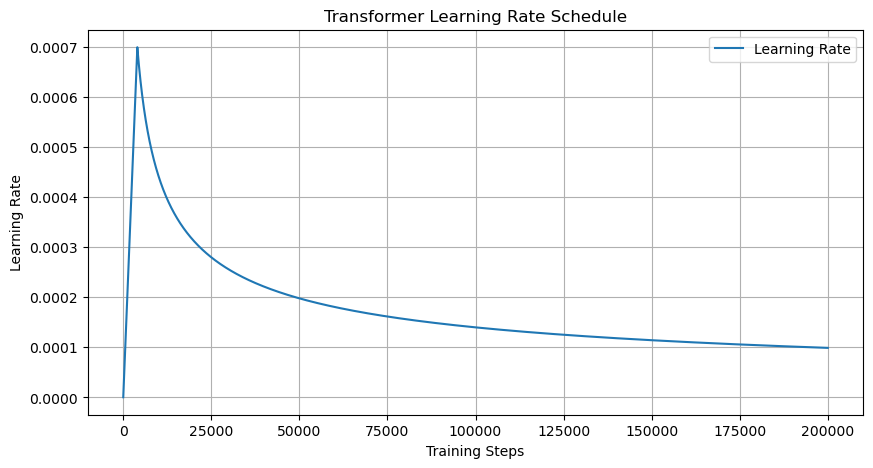

In [42]:
#그러면 방금 정의한 커스텀 학습률 스케줄링 계획을 시각화해 봅시다.
# 하이퍼파라미터 설정
d_model = 512
warmup_steps = 4000
total_steps = 200000  # 총 학습 스텝

# 학습률 스케줄 시각화
steps = np.arange(1, total_steps + 1)
learning_rates = [get_lr_lambda(d_model, warmup_steps)(step) for step in steps]

# 그래프 출력
plt.figure(figsize=(10, 5))
plt.plot(steps, learning_rates, label="Learning Rate")
plt.xlabel("Training Steps")
plt.ylabel("Learning Rate")
plt.title("Transformer Learning Rate Schedule")
plt.legend()
plt.grid(True)
plt.show()


In [43]:
# 4. 모델 컴파일
# 손실 함수와 커스텀 된 학습률(learning rate)을 사용하여 모델을 컴파일합니다.
# Optimizer 정의
optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-9)

# Scheduler 정의
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda(D_MODEL, warmup_steps=4000))

def accuracy_function(y_pred, y_true, pad_id=0):
    """
    y_pred: (batch_size, seq_len, vocab_size)
    y_true: (batch_size, seq_len)
    """
    preds = y_pred.argmax(dim=-1)  # (batch_size, seq_len)
    mask = (y_true != pad_id)
    correct = (preds == y_true) & mask
    acc = correct.float().sum() / mask.float().sum()
    return acc

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

NameError: name 'model' is not defined

In [45]:
# 5. 훈련하기
# 이제 학습을 진행해 봅시다.
def train_step(model, batch, optimizer, loss_function, device):
    model.train()
    enc_input, dec_input, target = [x.to(device) for x in batch]

    optimizer.zero_grad()

    # 모델 포워드 패스
    logits = model(enc_input, dec_input)  # (batch_size, seq_len, vocab_size)

    # Loss 계산 (패딩 토큰 무시)
    loss = loss_function(logits.permute(0, 2, 1), target)  # (batch_size, vocab_size, seq_len) 필요

    # Backpropagation
    loss.backward()
    optimizer.step()

    return loss.item(), accuracy_function(logits, target, pad_id=sp.pad_id())

In [46]:
def train(model, dataloader, optimizer, loss_function, scheduler, num_epochs, device):
    model.to(device)

    for epoch in range(num_epochs):
        total_loss, total_acc = 0, 0
        for step, batch in enumerate(dataloader):
            loss, acc = train_step(model, batch, optimizer, loss_function, device)
            total_loss += loss
            total_acc += acc

            # 일정 스텝마다 로그 출력
            if step % 100 == 0:
                print(f"[Epoch {epoch+1}, Step {step}] Loss: {loss:.4f}, Acc: {acc:.4f}")

            # 학습률 스케줄러 업데이트
            scheduler.step()

        avg_loss = total_loss / len(dataloader)
        avg_acc = total_acc / len(dataloader)
        print(f"Epoch {epoch+1} Completed - Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.4f}")

In [47]:
%%time

train(
    model=model,
    dataloader=dataloader,
    optimizer=optimizer,
    loss_function=loss_function,
    scheduler=scheduler,
    num_epochs=25,  # 원하는 에폭 수
    device=device
)

[Epoch 1, Step 0] Loss: 9.1115, Acc: 0.0000
[Epoch 1, Step 100] Loss: 9.1383, Acc: 0.0000
[Epoch 1, Step 200] Loss: 9.1872, Acc: 0.0000
[Epoch 1, Step 300] Loss: 9.1698, Acc: 0.0000
[Epoch 1, Step 400] Loss: 9.1322, Acc: 0.0000
[Epoch 1, Step 500] Loss: 9.1899, Acc: 0.0000
[Epoch 1, Step 600] Loss: 9.1286, Acc: 0.0000
[Epoch 1, Step 700] Loss: 9.1356, Acc: 0.0000
[Epoch 1, Step 800] Loss: 9.1188, Acc: 0.0000
[Epoch 1, Step 900] Loss: 9.1172, Acc: 0.0000
[Epoch 1, Step 1000] Loss: 9.0408, Acc: 0.0000
[Epoch 1, Step 1100] Loss: 9.0744, Acc: 0.0000
[Epoch 1, Step 1200] Loss: 8.9865, Acc: 0.0117
[Epoch 1, Step 1300] Loss: 8.9644, Acc: 0.0000
Epoch 1 Completed - Avg Loss: 9.0978, Avg Acc: 0.0005
[Epoch 2, Step 0] Loss: 9.0243, Acc: 0.0053
[Epoch 2, Step 100] Loss: 8.9512, Acc: 0.0000
[Epoch 2, Step 200] Loss: 8.8871, Acc: 0.0028
[Epoch 2, Step 300] Loss: 8.8323, Acc: 0.0120
[Epoch 2, Step 400] Loss: 8.8147, Acc: 0.0056
[Epoch 2, Step 500] Loss: 8.8090, Acc: 0.0082
[Epoch 2, Step 600] Loss: 

In [48]:
# 14. 챗봇 테스트하기

def decoder_inference(model, sentence, tokenizer, device='cpu'):
    START_TOKEN = tokenizer.bos_id()
    END_TOKEN = tokenizer.eos_id()
    MAX_LENGTH = 40


    # 전처리
    sentence = preprocess_sentence(sentence)

    # 인코더 입력: [START] + 인코딩 + [END]
    enc_input_ids = [START_TOKEN] + tokenizer.encode(sentence) + [END_TOKEN]
    # 차원 확장: (batch_size=1, seq_len)
    enc_input = torch.tensor([enc_input_ids], dtype=torch.long, device=device)

    # 디코더 입력(dec_input)을 START_TOKEN만 포함한 상태로 시작
    dec_input = torch.tensor([[START_TOKEN]], dtype=torch.long, device=device)

    model.eval()  # 모델 평가 모드
    with torch.no_grad():
        for i in range(MAX_LENGTH):
            # 모델 forward: (enc_input, dec_input) -> (batch_size=1, seq_len, vocab_size)
            logits = model(enc_input, dec_input)

            # 마지막 타임스텝의 예측만 추출: shape (1, 1, vocab_size)
            # logits[:, -1, :] -> (1, vocab_size)
            last_step_logits = logits[:, -1, :]

            # argmax로 가장 높은 확률의 토큰 선택
            predicted_id = torch.argmax(last_step_logits, dim=-1)  # shape: (1,)

            # 종료 토큰이면 중단
            if predicted_id.item() == END_TOKEN:
                break

            # 디코더 입력(dec_input)에 예측 토큰을 이어붙임
            predicted_id = predicted_id.unsqueeze(0)  # shape (1,1)
            dec_input = torch.cat([dec_input, predicted_id], dim=1)

    # 최종 시퀀스: dec_input: (1, seq_len)에서 (seq_len,)로
    output_sequence = dec_input.squeeze(0).tolist()  # e.g. [START_TOKEN, ..., 토큰들...]

    return output_sequence

In [49]:
# 임의의 입력 문장에 대해서 decoder_inference() 함수를 호출하여 챗봇의 대답을 얻는 
# sentence_generation() 함수를 만듭니다.

def sentence_generation(model, sentence, tokenizer, device='cpu'):
    # 디코더 인퍼런스 -> 예측된 토큰 시퀀스
    output_seq = decoder_inference(model, sentence, tokenizer, device=device)

    # 토크나이저로 디코딩 (패딩, START/END 토큰 등은 제외하거나 처리)
    # 여기서는 단순히 tokenizer.decode() 직접 호출
    predicted_sentence = tokenizer.decode(
        [token for token in output_seq if token < tokenizer.GetPieceSize()]
    )

    print("입력 :", sentence)
    print("출력 :", predicted_sentence)
    return predicted_sentence

In [50]:
# 임의의 문장으로부터 챗봇의 대답을 얻어봅시다.
sentence = 'Where have you been?'
sentence_generation(model, sentence, sp, device)

입력 : Where have you been?
출력 : i m .


'i m .'

In [51]:
sentence = "It's a trap"
sentence_generation(model, sentence, sp, device)

입력 : It's a trap
출력 : i m .


'i m .'

In [ ]:
sentence = "It's a trap"
sentence_generation(model, sentence, sp, device)